> [View this notebook on Kaggle](https://www.kaggle.com/code/nabeelvalley/time-series-analysis-with-stumpy)

> Notes on [Modern Time Series Analysis with STUMPY || Sean Law](https://www.youtube.com/watch?v=cCJy6hzAJQQ) and [STUMPY Docs](https://stumpy.readthedocs.io/en/latest/index.html)

# Overview

When the number of datapoints we're analyzing becomes large it can become very difficult to analyze data and find trends, identify seasonality, or find outliers

Things we can normally do with time series data

- Visualize
- Statistical Analysis
- ARIMA
- Anomaly Detection
- Forecasting
- Machine Learning
- Clustering
- Dynamic Time Warping
- Deep Learning

There's generally no solution that will work for everything. Each method comes with some comprimise

# The Goal

> "If a behaviour is conserved, there must have been a reason why it was conserved and teasing out the reasons/causes is often very useful"

When considering the above, we can ask the two following questions:

- Do any conserved behaviours exist in my data?
- If there are conserved behaviours, what are they and where are they?

> A subsequence is a part of the full sequence over time

# The Solution

We want our solution to be:

- Easy to interpret
- User/Data agnostic
- No Prior Knowledge - don't need training
- Parameter free or have intuitive parameters

# Distance Matrices

Comparison between sequences can be done by looking at the euclidean distance between all the points in two subsequences:

![Euclidean Distance](https://stumpy.readthedocs.io/en/latest/_images/euclidean_distance.jpeg)

Using this idea, can we ask the question: is this sequence repeated?

We can calculate this by sliding a window over different parts of our data and calculating the distance between these subsequences:

![Distance between subsequences](https://stumpy.readthedocs.io/en/latest/_images/pairwise_euclidean_distance.gif)

The result of the above is called a distance profile, in order to check if the sequence is preserved we look for the next closest match. We can do this by computing a distance matrix which shows us the sequence combinations that are repeated through the data:

![Distance matrix](https://stumpy.readthedocs.io/en/latest/_images/distance_matrix.jpeg)

The above solution, however, is not very scalable since it's got a high computational time and space using a brute force method in order to calculate the distance matrix

# Matrix Profile

In order to get around the time/space problem when calculating the distance matrix we have the idea of a Matrix Profile

> "A Matrix Profile is a vector that stores the distance (normalized, z-index, euclidean) between each subsequence within a time series and its nearest neighbor"

![Matrix Profile from Distance Matrix](https://stumpy.readthedocs.io/en/latest/_images/matrix_profile.gif)

This is basically the closest distances only stored and can be used to annotate the tim series that we have

We can find conserved subsequences by looking at the minumum of the matrix profile, for example:

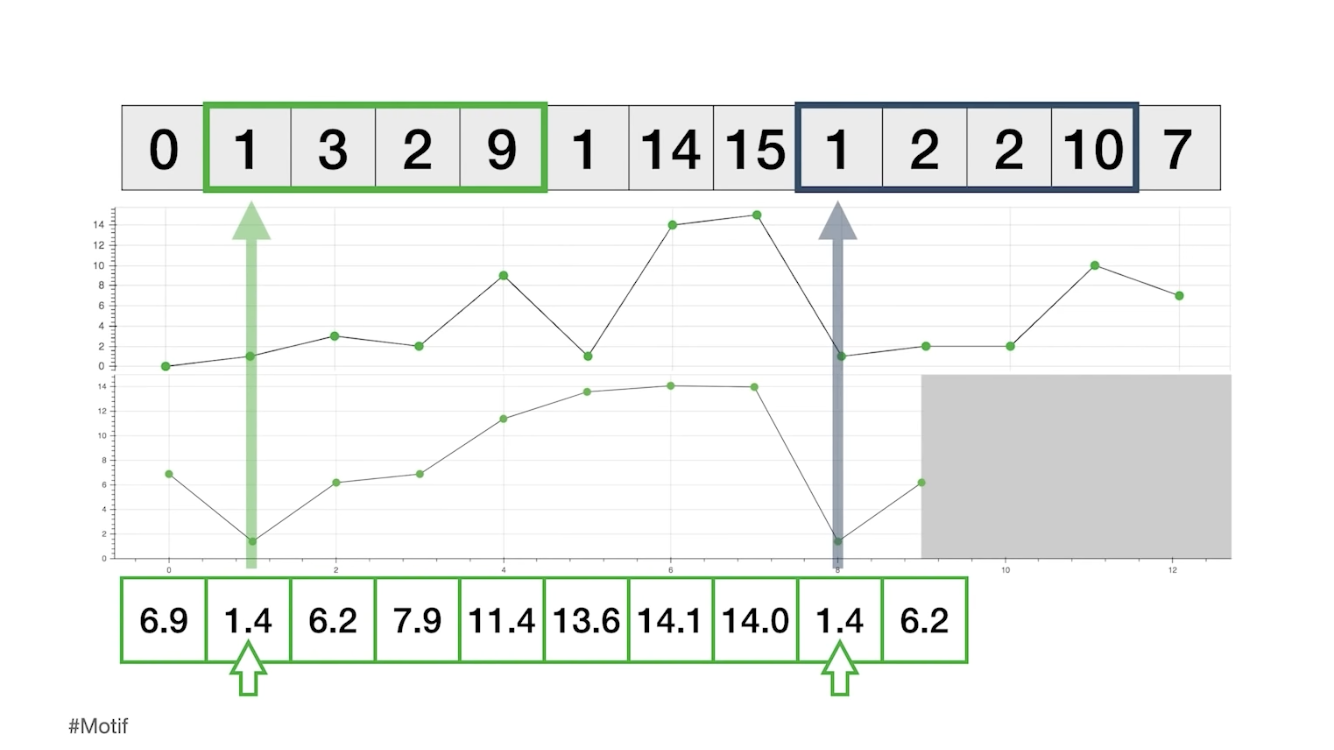

The consered subsequence is known as a Motif

# Matrix Profile Index

> "A Matrix Profile Index is the index (location) of the nearest neighbor for a given subsequence"

The matrix profile index tells us where is the nearest location of a subsequence:

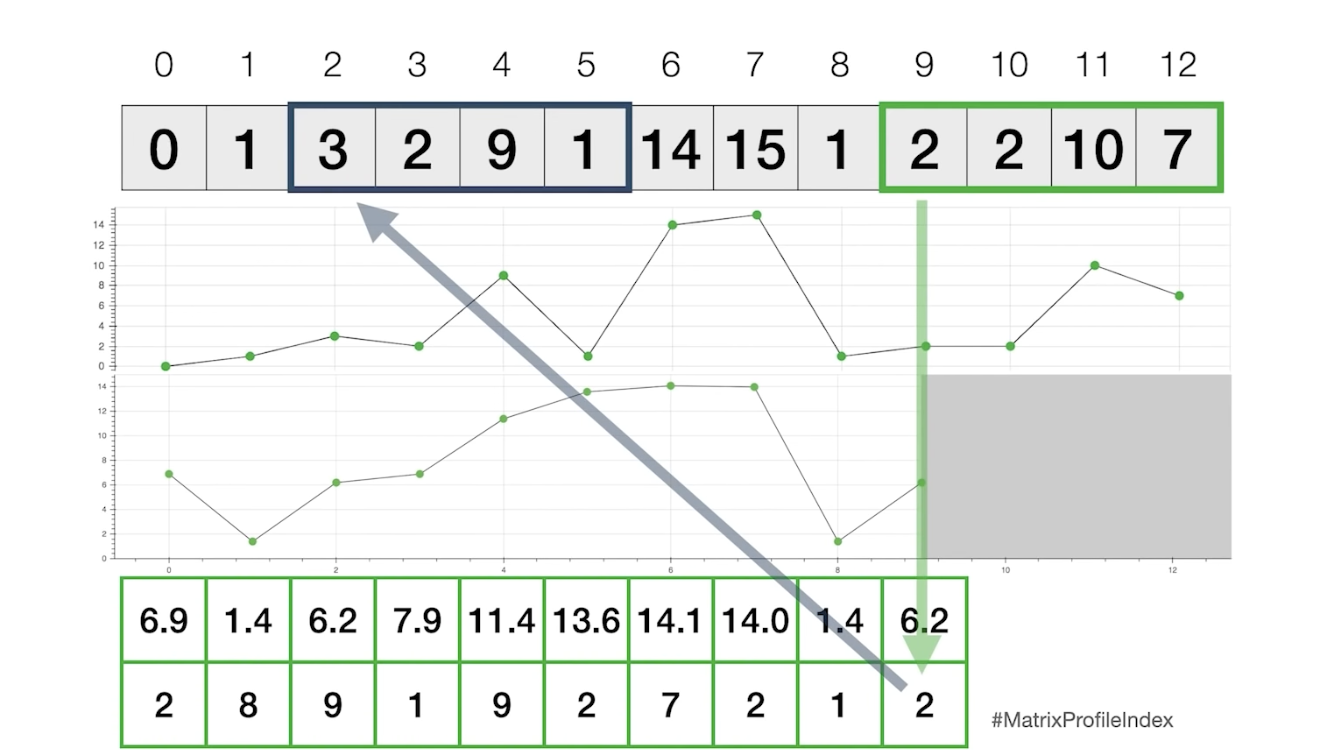

A potential discord/anomaly can be found by looking at the largest value in the matrix profile:

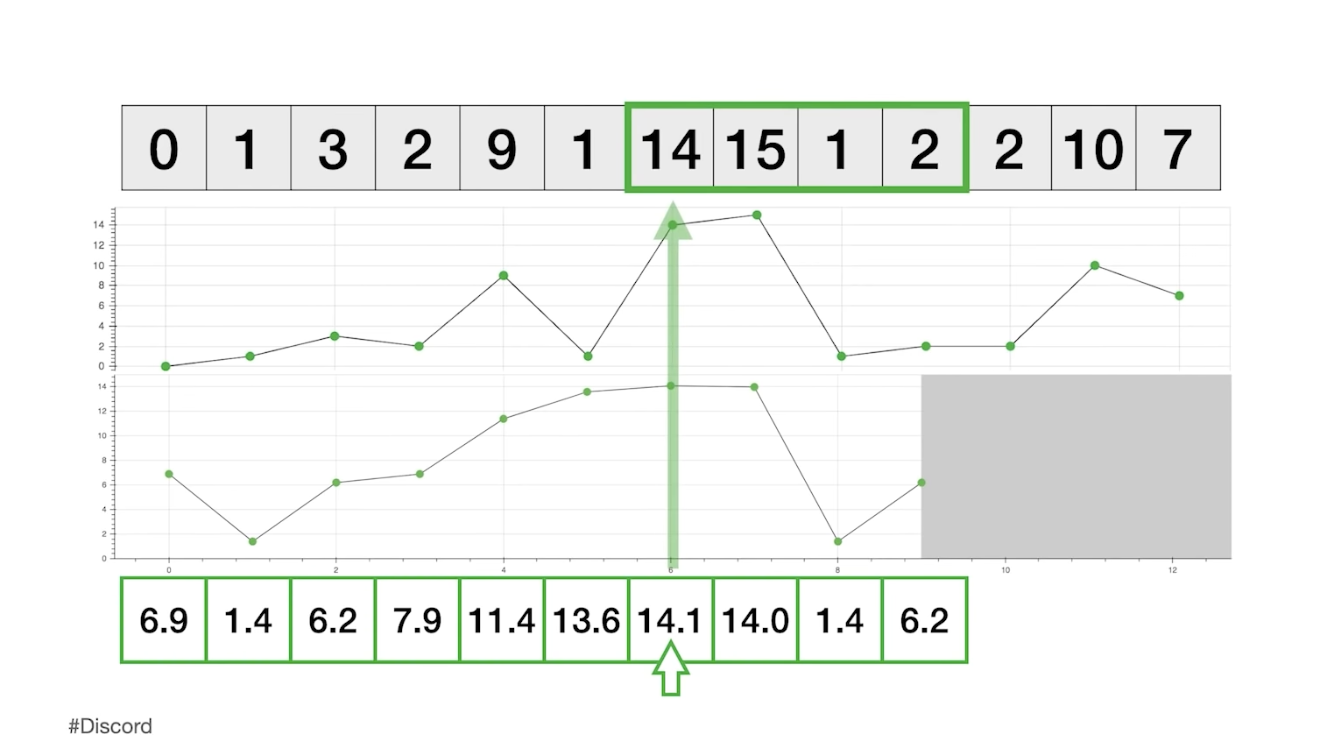

Since this segment is most different to all other datapoints in the sequence

# Algorithms for Calculating Matrix Profiles

| Algorithm   | Type     | Time Complexity | Space Complexity |
| ----------- | -------- | --------------- | ---------------- |
| Brute Force | Naive    | $O(n^2m)$       | $O(n^2)$         |
| STAMP       | FFT      | $O(n^2logn)$    | $O(n)$           |
| STOMP       | Algebra  | $O(n^2)$        | $O(n)$           | 
| GPU-STOMP   | Hardware | $O(n^2)$        | $O(n)$           |

## STUMPY

STUMPY is a python library implementation of STOMP and has support for:

- STUMP - implementation of STUMP 
- GYP-STUMP - STUMP with GPU
- MSTUMP - multi-data STUMP
- SCRUMP - approximate matrix profiles
- STUMPI - STUMP for streaming data

STUMPY is designed to be used along with the above mentioned methods and can be used for doing time base analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import stumpy

In [2]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


In [3]:
y = steam_df['steam flow']
x = steam_df.index

In [4]:
m = 640
matrix_profile = stumpy.stump(y, m)

In [5]:
matrix_profile

array([[16.235411477247848, 2242, -1, 2242],
       [16.08191866323064, 2243, -1, 2243],
       [15.909403017873458, 2245, -1, 2245],
       ...,
       [9.022931372214867, 877, 877, -1],
       [9.0382596759492, 878, 878, -1],
       [9.054692514421166, 879, 879, -1]], dtype=object)

In [6]:
matrix_profile_df = pd.DataFrame(matrix_profile, columns=['profile', 'profile index', 'left profile index', 'right profile index'])

matrix_profile_df.tail(10)

,profile,profile index,left profile index,right profile index
8951,8.937284,871,871,-1
8952,8.949783,872,872,-1
8953,8.96176,873,873,-1
8954,8.974059,873,873,-1
8955,8.986255,874,874,-1
8956,8.997375,875,875,-1
8957,9.009344,876,876,-1
8958,9.022931,877,877,-1
8959,9.03826,878,878,-1
8960,9.054693,879,879,-1


## Find the Best Motif

The best motif is the one where the profile is the smallest (since the profile is the distance value)

Checking for the minimum will give us two matches, each of these should refer to each other which can be seen by looking at the profile index:

In [7]:
best_motif = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].min()]
best_motif

,profile,profile index,left profile index,right profile index
643,5.49162,8724,296,8724
8724,5.49162,643,643,8960


We can plot this motif below:

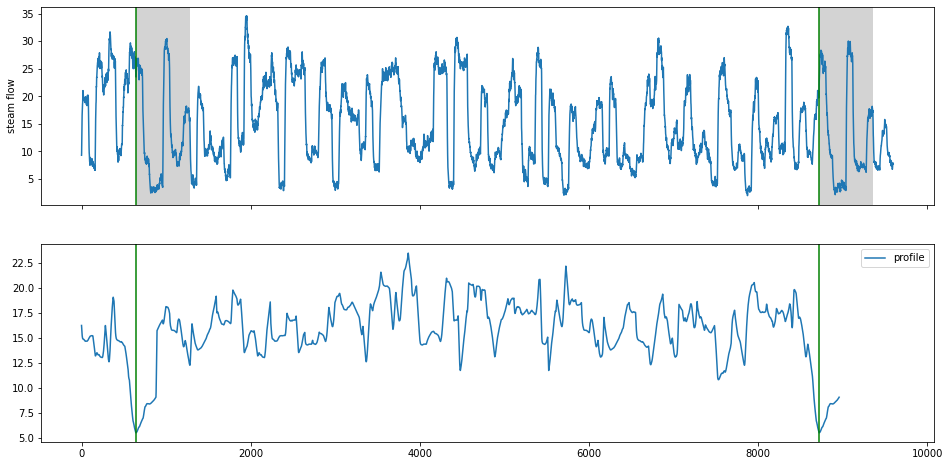

In [8]:
profile_df = matrix_profile_df[['profile']]

fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)
g1 = sns.lineplot(y=y, x=x, ax=ax[0])
g2 = sns.lineplot(data=profile_df, ax=ax[1])

for idx in best_motif.index.to_list():
    g1.axvline(x=idx, color="green")
    g2.axvline(x=idx, color="green")
    rect = Rectangle((idx, 0), m, 40, facecolor="lightgrey")
    g1.add_patch(rect)

We can also view the above zoomed in:

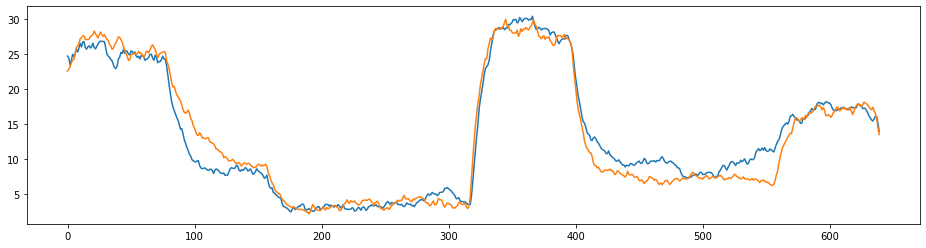

In [9]:
fig, ax = plt.subplots(figsize=(16,4))

for idx in best_motif.index.to_list():
    plot_y = y.iloc[idx:(idx+m)].to_list()
    sns.lineplot(data=plot_y, ax=ax)

Comparatively, we can compare two random subsequences which don't have any specific relation

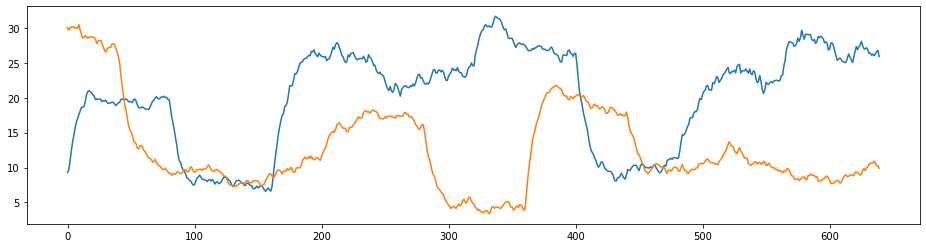

In [10]:
fig, ax = plt.subplots(figsize=(16,4))

for idx in [0, 1000]:
    plot_y = y.iloc[idx:(idx+m)].to_list()
    sns.lineplot(data=plot_y, ax=ax)

## Find a Discord

Potential discords/anomalies can be located as data that's most different to any existing datapoints, this can be found by finding the max profile distance. We can find the anomaly segment by getting this value and plotting it below:

In [11]:
discord = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].max()]
discord

,profile,profile index,left profile index,right profile index
3864,23.476168,4755,1864,4755


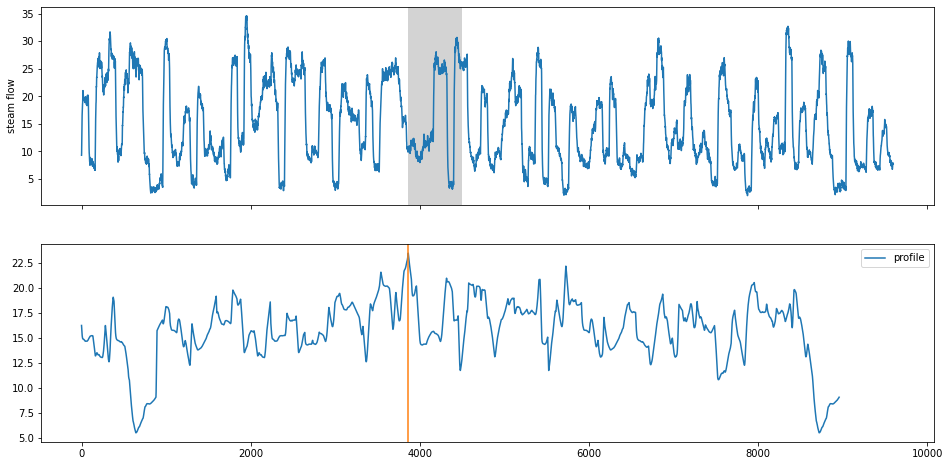

In [12]:
fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)
g1 = sns.lineplot(y=y, x=x, ax=ax[0])
g2 = sns.lineplot(data=profile_df, ax=ax[1])


rect = Rectangle((discord.index[0], 0), m, 40, facecolor="lightgrey")
g1.add_patch(rect)
g2.axvline(x=[discord.index[0]], color='C1')

# Time Series Chains

Time series chains are like motifs that evolve and drift over time

A Time series chain can be visualized as a set of motifs that have a close match in some direction, for example the red/green arrows below:

![Time series chains](https://stumpy.readthedocs.io/en/latest/_images/Tutorial_Time_Series_Chains_7_0.png)

## Time Series Chain Data

An example dataset for time series chains is the "Kohl" search volume on google

<AxesSubplot:>

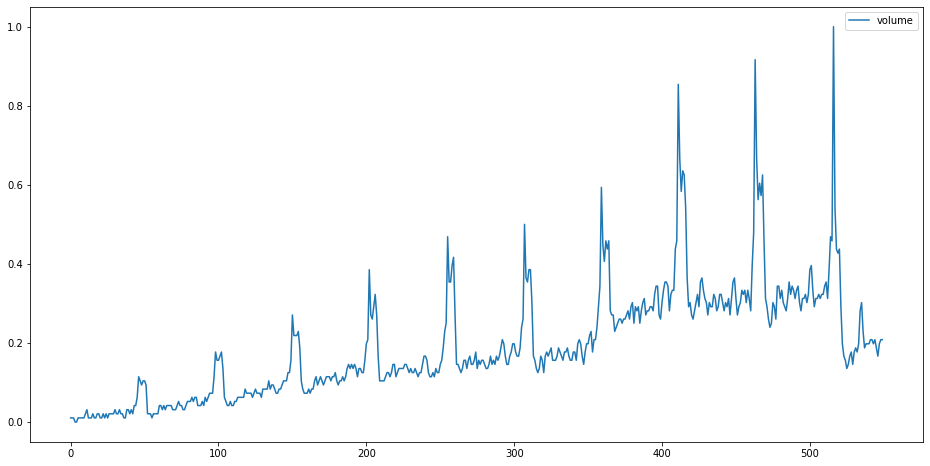

In [13]:
df_search = pd.read_csv("https://zenodo.org/record/4276348/files/Time_Series_Chains_Kohls_data.csv?download=1")

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=df_search, ax=ax)

## Calculate the Matrix Profile

Calculating the matrix profile can be done as normal:

In [14]:
m = 20
mp_search = stumpy.stump(df_search['volume'], m=m)

mp_search_df = pd.DataFrame(mp_search, columns=['profile', 'profile index', 'left profile index', 'right profile index'])
mp_search_df.head()

,profile,profile index,left profile index,right profile index
0,3.329265,490,-1,490
1,3.079098,209,-1,209
2,2.904647,210,-1,210
3,2.640721,211,-1,211
4,2.898221,212,-1,212


<AxesSubplot:>

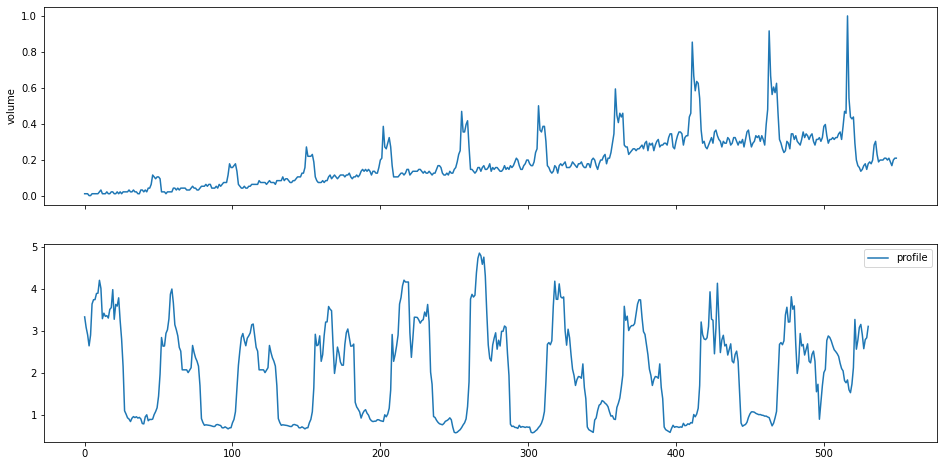

In [15]:
fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)

sns.lineplot(data=df_search['volume'], ax=ax[0])
sns.lineplot(data=mp_search_df[['profile']], ax=ax[1])


In the above we can see the growing pattern but we can also see sections where the matrix profile is small which means there is minimal difference between subsequences

## Calculate Chains

We can calculate the chains in the dataset by using the `allc` function which also returns the unanchored chain (longest chain) which takes the left profile index and the right profile index:

In [16]:
all_chain_set, unanchored_chain = stumpy.allc(mp_search[:, 2], mp_search[:, 3])

unanchored_chain

array([ 35,  87, 139, 244, 296, 400, 452])

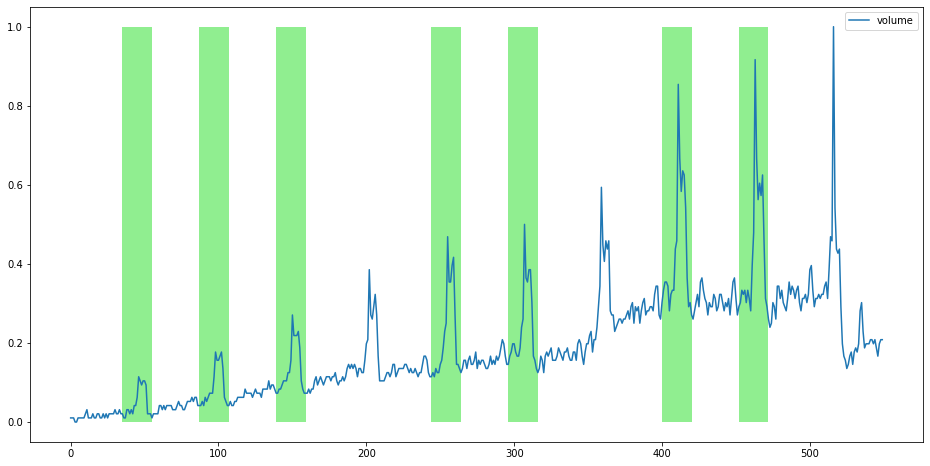

In [17]:
fig, ax = plt.subplots(figsize=(16,8), sharex=True)

sns.lineplot(data=df_search)

for idx in unanchored_chain:
    rect = Rectangle((idx, 0), m, 1, facecolor="lightgreen")
    ax.add_patch(rect)

From the above we can identify which segments were identified as being part of the chain, we can also see that some points are missed - this could be due to undersampling of the data or that the datapoints are less similar than other comparative datapoints

# Semantic Segmentation

An analysiss we can we can perform on increasing data quantities is segmentation. Can we take a long series of data and chop it into `k` regions where `k` is small wuth the goal of passigng it on to a human or machine annotator

FLUSS can be used to do this kind of analysis, for our sake let's take the above data and select the timeframe of a single bump:

In order to calculate the regimes we need to get the matrix profile of the input data:

Note that the segments account for segmentation between regimes - i.e. there is a split in the relationship of the data on each side of the input data - the two parts have their own profile relations

Calculatting the regimes depends on the profile index and not necessarily the profile value itself

We can try to ssegment the data into 3 regimes using the below

In [18]:
L = m
regimes = 3
cac, regime_locations = stumpy.fluss(mp_search[:, 1], L=L, n_regimes=regimes, excl_factor=1)

Note that we only have 2 locations as a result, this is because the `regime_locations` indicate the regime changeover points - the ranges can be inferred from these

In [19]:
regime_locations

array([159, 247])

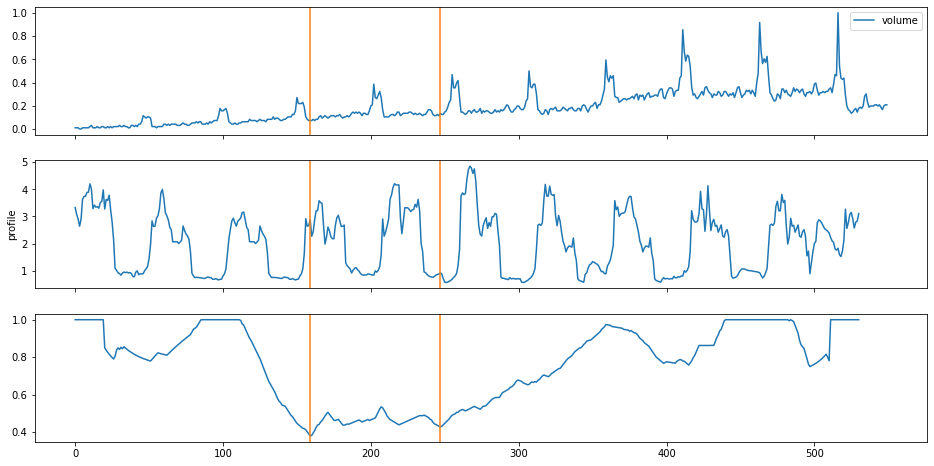

In [20]:
fig, ax = plt.subplots(3, figsize=(16,8), sharex=True)

sns.lineplot(data=df_search, ax=ax[0])
sns.lineplot(data=mp_search_df['profile'], ax=ax[1])
sns.lineplot(data=cac, ax=ax[2])

for idx in regime_locations:
    for adx in ax:
        adx.axvline(x=idx, color='C1')
    

The basic process for segmentation is the same for any given number of segments and the code above is generic with regards to that

## Fast Pattern Matching

We can use STUMPY to find predefined patterns in data, this can also be much more efficient than trying to find general patterns in a dataset 

This can be visualized by trying to query for patterns in the Sony AIBO Robot Dog Dataset:

In [21]:
search_df = pd.read_csv("https://zenodo.org/record/4276393/files/Fast_Pattern_Searching_robot_dog.csv?download=1")
search_df.head()

,Acceleration
0,0.89969
1,0.89969
2,0.89969
3,0.89969
4,0.89969


We can plot the data below, showing the carpet section with the grey background

<AxesSubplot:>

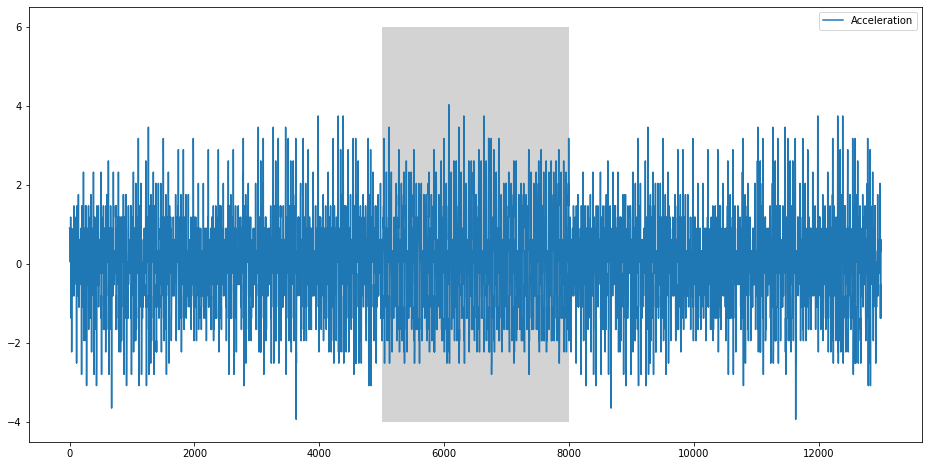

In [22]:
fig, ax = plt.subplots(figsize=(16,8))


# carpet section
rect = Rectangle((5000, -4), 3000, 10, facecolor="lightgrey")
ax.add_patch(rect)

sns.lineplot(data=search_df, ax=ax)

We can use the query data which is a segment that identifies data from when the robot was om the carpet:

In [23]:
query_df = pd.read_csv("https://zenodo.org/record/4276880/files/carpet_query.csv?download=1")
query_df.head()

,Acceleration
0,0.111111
1,0.111111
2,0.128205
3,0.111111
4,0.111111


> It's also relevant to note that the data in the query is not scaled the same as the data in the search sequence, this will be handles appropriately be stumpy which will do a z-normalization when calculating distances

<AxesSubplot:>

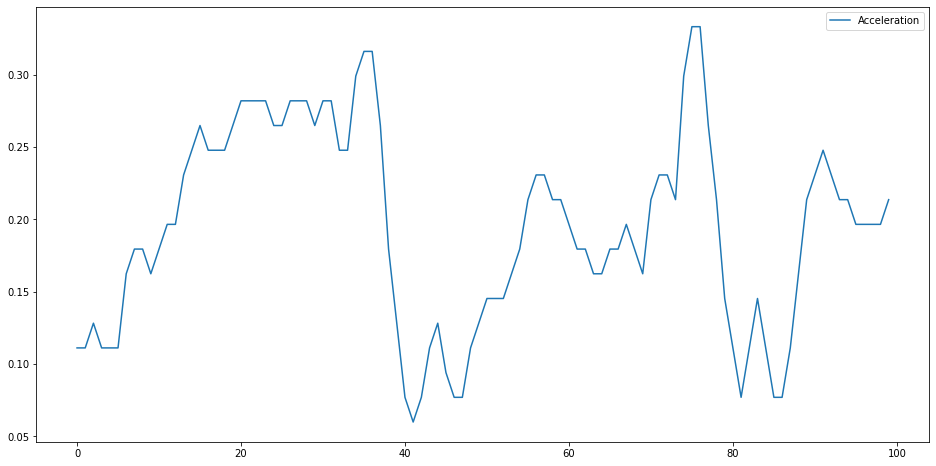

In [24]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(data=query_df, ax=ax)

The `stumpy.mass` function will look for this segment in the given data:

In [25]:
distance_profile = stumpy.mass(query_df['Acceleration'], search_df['Acceleration'])
distance_profile_df = pd.DataFrame(distance_profile)

distance_profile_df.head()

,0
0,15.617256
1,15.400917
2,15.146692
3,14.894353
4,14.690273


We can sort the distance profiles to find the index with the best fit:

In [26]:
distance_profile_df_sorted = distance_profile_df.sort_values(0)
distance_profile_df_sorted.head()

,0
7479,3.954503
6999,4.103417
7719,4.331618
7478,4.391748
7559,4.462875


We can then plot the nearest few matches along with the original data:

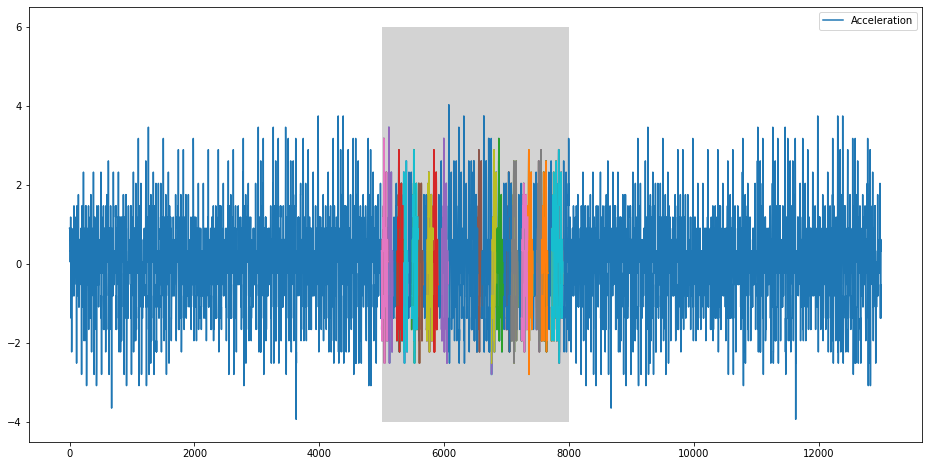

In [27]:
fig, ax = plt.subplots(figsize=(16, 8))

# carpet section
rect = Rectangle((5000, -4), 3000, 10, facecolor="lightgrey")
ax.add_patch(rect)

sns.lineplot(data=search_df, ax=ax)

compare_len, _ = query_df.shape
for idx in range(50):
    index = distance_profile_df_sorted.index[idx]
    match_data = search_df.iloc[index:index+compare_len]
    ax.plot(match_data)


We can also take a zoomed in view of the above plot just into the carped segment:

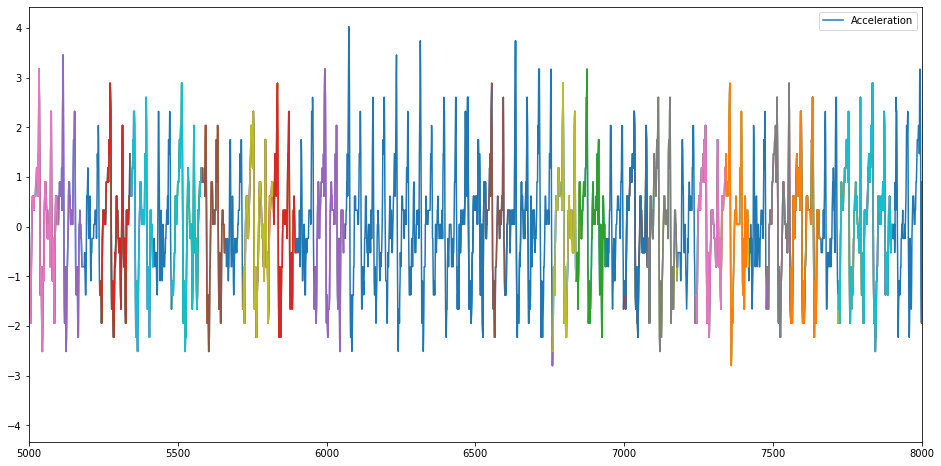

In [28]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim([5000, 8000])

sns.lineplot(data=search_df, ax=ax)

compare_len, _ = query_df.shape
for idx in range(50):
    index = distance_profile_df_sorted.index[idx]
    match_data = search_df.iloc[index:index+compare_len]
    ax.plot(match_data)


STUMPY also has a `match` function that can be used to do the sorting and index matching for us:

In [29]:
matches = stumpy.match(query_df["Acceleration"], search_df["Acceleration"])
matches_df = pd.DataFrame(matches, columns=["distance profile", "index"])

matches_df.head()

,distance profile,index
0,3.954503,7479
1,4.103417,6999
2,4.331618,7719
3,4.462875,7559
4,4.545081,7799


We can see that the above dataframe matches what we computed above

All matching segments can be plotted from the above list and we can build an understanding for how they compare:

> Note that STUMPY makes use of z-normalized euclidean distances when comparing data, so we would want to normalize subsequences when plotting for comparison

We can see the normalized sequences that match below, with the white line being the query sequence

<AxesSubplot:>

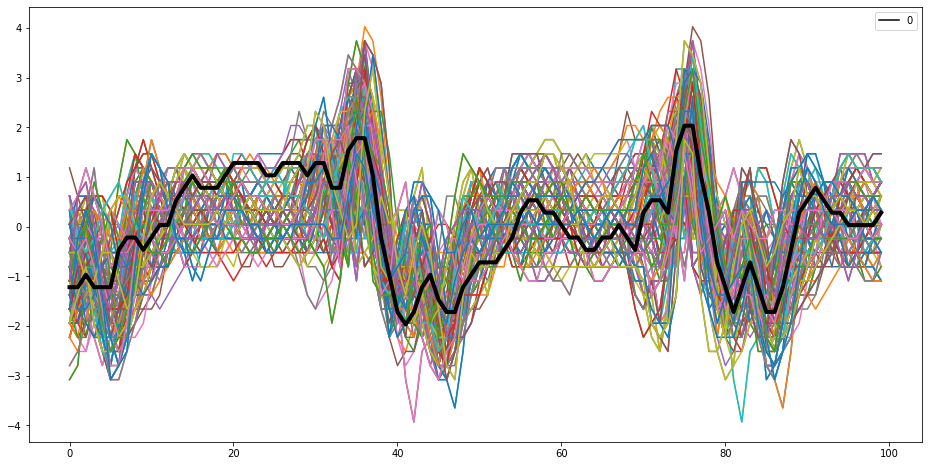

In [30]:
query_df_norm = stumpy.core.z_norm(query_df.values)

fig, ax = plt.subplots(figsize=(16,8))

compare_len, _ = query_df.shape
for _, idx in matches:
    match_data = search_df.iloc[idx:idx+compare_len].values
    ax.plot(match_data)
    
sns.lineplot(data=query_df_norm, ax=ax, lw=4, palette=['black'])

We can also provide a maximum matching distance that we care about for similarity in order to get matches within a specific range. The default value for this is specified as two standard deviations from the mean: `max_distance = max(np.mean(D) - 2 * np.std(D), np.min(D))`, but we can change this:

<AxesSubplot:>

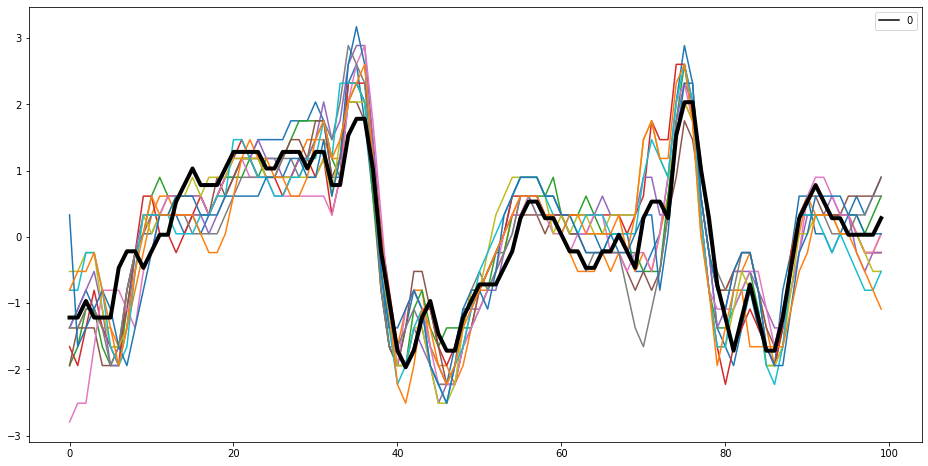

In [31]:
matches_max_dist = stumpy.match(
    query_df["Acceleration"], 
    search_df["Acceleration"],
    max_distance=lambda D: max(np.mean(D) - 4 * np.std(D), np.min(D))
)

query_df_norm = stumpy.core.z_norm(query_df.values)

fig, ax = plt.subplots(figsize=(16,8))

compare_len, _ = query_df.shape
for _, idx in matches_max_dist:
    match_data = search_df.iloc[idx:idx+compare_len].values
    ax.plot(match_data)
    
sns.lineplot(data=query_df_norm, ax=ax, lw=4, palette=['black'])

Or more simply, we can just define the number of matches with `max_matches`:

<AxesSubplot:>

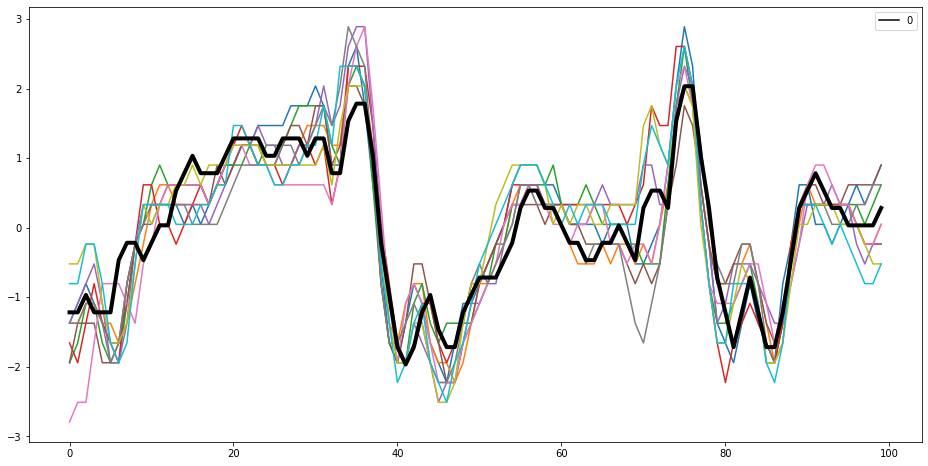

In [32]:
matches_max_lim = stumpy.match(
    query_df["Acceleration"], 
    search_df["Acceleration"],
    max_matches=10
)

query_df_norm = stumpy.core.z_norm(query_df.values)

fig, ax = plt.subplots(figsize=(16,8))

compare_len, _ = query_df.shape
for _, idx in matches_max_lim:
    match_data = search_df.iloc[idx:idx+compare_len].values
    ax.plot(match_data)
    
sns.lineplot(data=query_df_norm, ax=ax, lw=4, palette=['black'])

# Finding Conserved Patterns Across Two Time Series (AB-Join)

The `stump` method can find matching sequences in a single series as we have done before, but it can also be used to find motifs between two sequences of audio frequency data:

The matrix profile for these two sequences is done using an AB-Join

In [33]:
df_a = pd.read_csv("https://zenodo.org/record/4294912/files/queen.csv?download=1")
df_b = pd.read_csv("https://zenodo.org/record/4294912/files/vanilla_ice.csv?download=1")

In [34]:
df_a.head()

,under_pressure
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [35]:
df_b.head()

,ice_ice_baby
0,-10.992350
1,-11.066199
2,-11.019284
3,-9.691009
4,-10.698435


Below is the method for identifying common motifs between the two datasets:

In [36]:
m = 500
mp_a = stumpy.stump(
    T_A=df_a['under_pressure'], 
    T_B=df_b['ice_ice_baby'], 
    m=m, 
    # we want trivial matches since the sequences being compared are different
    ignore_trivial=False
)

We can compare the results of the profile below:

<AxesSubplot:>

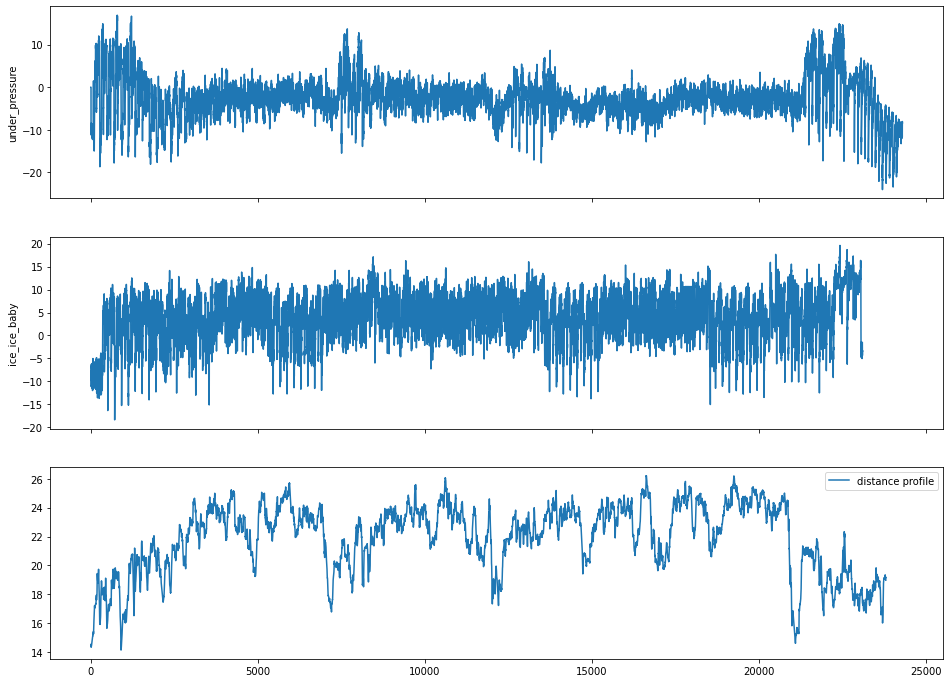

In [37]:
fig, ax = plt.subplots(3, figsize=(16,12), sharex=True)

sns.lineplot(data=df_a['under_pressure'], ax=ax[0])
sns.lineplot(data=df_b['ice_ice_baby'], ax=ax[1])
sns.lineplot(data=mp_a[:, 0], label="distance profile", ax=ax[2]) 

In the above plot we can see two minimum values, along with their timestamps:

In [38]:
mp_a_df = pd.DataFrame(
    mp_a, 
    columns=['distance profile', 'compared index', 'left index', 'right index']
).sort_values('distance profile')

mp_a_df['local index'] = mp_a_df.index

mp_a_df.head()

,distance profile,compared index,left index,right index,local index
904,14.135457,288,-1,-1,904
905,14.145091,289,-1,-1,905
906,14.162795,290,-1,-1,906
907,14.180128,291,-1,-1,907
903,14.190447,287,-1,-1,903


In [39]:
mp_a_min = mp_a_df.iloc[0]
mp_a_min

distance profile    14.135457
compared index            288
left index                 -1
right index                -1
local index               904
Name: 904, dtype: object

Once we have the above location, we can plot the two segments comparatively:

<AxesSubplot:>

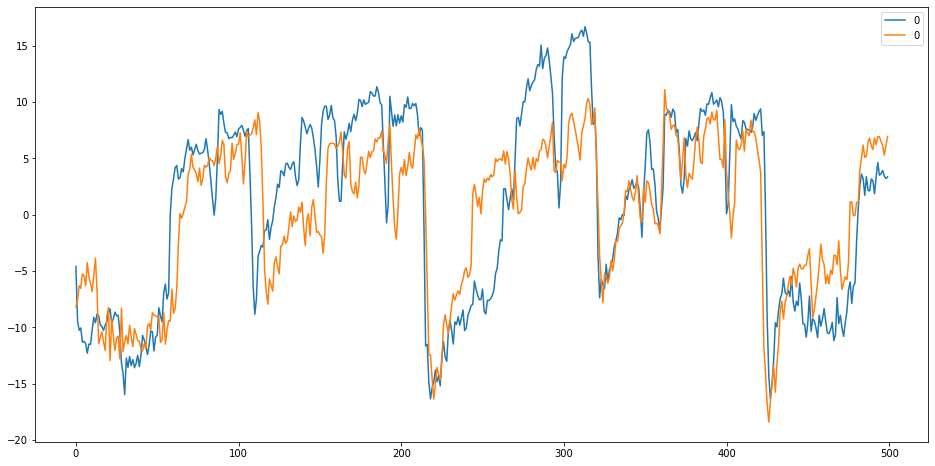

In [40]:
index_a = mp_a_min['local index']
index_b = mp_a_min['compared index']

fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(data=df_a.iloc[index_a:index_a+m].values, ax=ax)
sns.lineplot(data=df_b.iloc[index_b:index_b+m].values, ax=ax, palette=['C1'])


# Consensus Motifs

Consensus motifs are patterns that are conserved across all time series within a set

The Ostinato algorithm is an efficient way of finding consensus motifs:

In [41]:
import stumpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import linkage, dendrogram

We can use the mtDNA sequnce dataset to cluster different series by comparing them to each other. To do this we first need to read the data for each of the animals:

In [42]:
animals = ['python', 'red_flying_fox', 'hippo', 'alpaca']
dna_seqs = {}
truncate = 15000
for animal in animals:
    dna_seqs[animal] = pd.read_csv(
        f"https://zenodo.org/record/4289120/files/{animal}.csv?download=1"
    ).iloc[:truncate, 0].values

<AxesSubplot:>

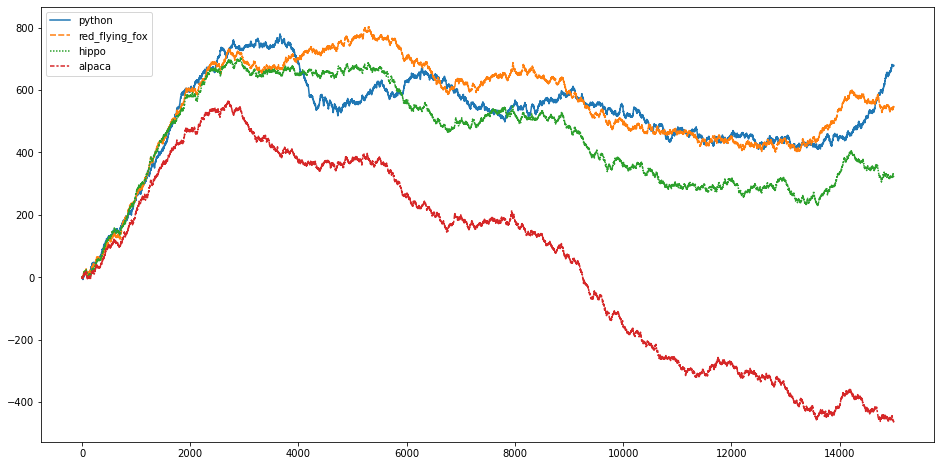

In [43]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(data=dna_seqs)

The `stumpy.ostinato` function can be used

In [44]:
m = 1000
radius, best_series, best_subseq_index = stumpy.ostinato(list(dna_seqs.values()), m)

radius, animals[best_series], best_subseq_index

(2.731288881859956, 'hippo', 602)

In [45]:
consensus_motif = list(dna_seqs.values())[best_series][
    best_subseq_index:best_subseq_index + m
]

Now that we have identified the consensus motif, we can extract each animal's closest motif:

In [46]:
dna_subseqs = {}
for animal in animals:
    match_index = np.argmin(stumpy.mass(consensus_motif, dna_seqs[animal]))
    subseq = dna_seqs[animal][match_index:match_index+m]
    dna_subseqs[animal] = stumpy.core.z_norm(subseq)

<AxesSubplot:>

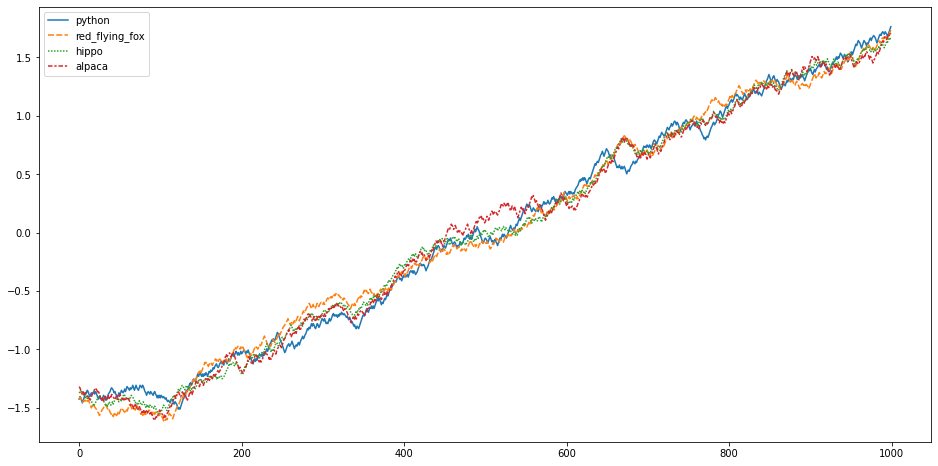

In [47]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=dna_subseqs, ax=ax)

In order to compare the data we can use clustering from `scipy`, in order to do this we compare the mass value from each 

In [48]:
pairwise_dists = []
for i, animal_1 in enumerate(animals):
    for animal_2 in animals[i+1:]:
        # compute the distance profile for the two sequences - since the sequences are the same
        # length this will yield a single item
        distance_profile = stumpy.mass(dna_subseqs[animal_1], dna_subseqs[animal_2])
        pairwise_dists.append(distance_profile[0])
        
pairwise_dists

[3.4426175122135096,
 2.731288881859265,
 3.24077399376529,
 2.386489385391013,
 3.26908334618909,
 2.061733644232989]

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [20.0, 20.0, 35.0, 35.0],
  [5.0, 5.0, 27.5, 27.5]],
 'dcoord': [[0.0, 2.061733644232989, 2.061733644232989, 0.0],
  [2.061733644232989, 2.386489385391013, 2.386489385391013, 0.0],
  [0.0, 2.731288881859265, 2.731288881859265, 2.386489385391013]],
 'ivl': ['python', 'alpaca', 'hippo', 'red_flying_fox'],
 'leaves': [0, 3, 2, 1],
 'color_list': ['C0', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C0', 'C0', 'C0']}

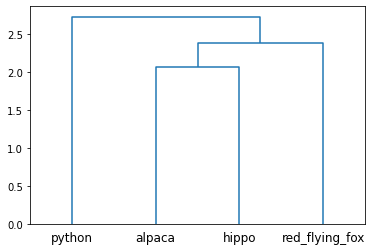

In [49]:
Z = linkage(pairwise_dists, optimal_ordering=True)
dendrogram(Z, labels=animals)

Looking at the above we can conclude that the closeness/clustering of the consensus motif in each dataset compared to the best sequence - hippo, the alpaca is most closely related, followed by the red flying fox, and then the python

# Resources/References

- https://matrixprofile.docs.matrixprofile.org/index.html
- https://www.cs.ucr.edu/~eamonn/100_Time_Series_Data_Mining_Questions__with_Answers.pdf
- https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html
- https://towardsdatascience.com/the-matrix-profile-e4a679269692